Import and config section

In [1]:
import tensorflow as tf
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

# This is needed to display the images.
%matplotlib inline

# Types of traffic lights
image_types = ["Red", "Green", "Yellow"]

# Activate optimizations for TF
config = tf.ConfigProto()
jit_level = tf.OptimizerOptions.ON_1
config.graph_options.optimizer_options.global_jit_level = jit_level

Load the trained models into TensorFlow

In [2]:
# Function to load a graph from a protobuf file
def load_graph(graph_file):
    with tf.Session(graph=tf.Graph(), config=config) as sess:
        gd = tf.GraphDef()
        with tf.gfile.Open(graph_file, 'rb') as f:
            data = f.read()
            gd.ParseFromString(data)
        tf.import_graph_def(gd, name='')
        return sess.graph

graph_detection = load_graph(os.path.join('model', 'model_detection.pb'))
graph_classification = load_graph(os.path.join('model', 'model_classification.pb'))
print("Models loaded!")

Models loaded!


Load the images from the test_images folder

In [10]:
# Those are the paths for our test images
image_paths = [ os.path.join('test_images', 'image{}.jpg'.format(i)) for i in range(0, 15) ]

# Load the images and store them into a list
images = []
for image_path in image_paths:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    images.append(image)
    
print("Test images loaded!")

Test images loaded!


Get the tensors from graph we need for detection

In [4]:
# Definite input and output Tensors for detection_graph
image_tensor = graph_detection.get_tensor_by_name('image_tensor:0')

# Each box represents a part of the image where a particular object was detected
detection_boxes = graph_detection.get_tensor_by_name('detection_boxes:0')

# Each score represent how level of confidence for each of the objects
detection_scores = graph_detection.get_tensor_by_name('detection_scores:0')

# This is the class from MS COCO dataset, we only need class 10 = traffic light
detection_classes = graph_detection.get_tensor_by_name('detection_classes:0')

# Get input and output tensors for the classification
in_graph = graph_classification.get_tensor_by_name('input_1_1:0')
out_graph = graph_classification.get_tensor_by_name('output_0:0')

This method extracts the traffic light bounding boxes with specified confidence level

In [5]:
def extractBox(boxes, scores, classes, confidence):
    # Prepare stuff
    boxes = np.squeeze(boxes)
    classes = np.squeeze(classes).astype(np.int32)
    scores = np.squeeze(scores)
        
    # Get bounding box with highest confidence
    maxConf = 0
    number = -1
    for i in range(boxes.shape[0]):
        if scores[i] > confidence and classes[i] == 10:
            if scores[i] > maxConf:
                maxConf = scores[i]
                number = i
                
    if number != -1:
        # Create a tuple for earch box
        box = tuple(boxes[number].tolist())
              
        # Extract box corners
        ymin, xmin, ymax, xmax = box
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width, 
                            ymin * im_height, ymax * im_height)
                
        # Expand them a little bit
        left = left - 5
        if left < 0:
            left = 0
        top = top - 10
        if top < 0:
            top = 0
        bottom = bottom + 10
        if bottom > im_height:
            bottom = im_height
        right = right + 5
        if right > im_width:
            right = im_width
        box = int(left), int(right), int(top), int(bottom)
        return box
    
    else:
        return None

With this method we can draw the bounding boxes and write labels for visualisation

In [6]:
def drawResult(box, label, image):
    font = cv2.FONT_HERSHEY_DUPLEX
    left, right, top, bottom = box
    cv2.rectangle(image, (left, top), (right, bottom), (255, 0, 0), 2)    
    cv2.putText(image, label, (left - 20, bottom + 40), font, 1, (255, 0, 0), 1, cv2.LINE_AA)
    return image

Do the inference here and show results

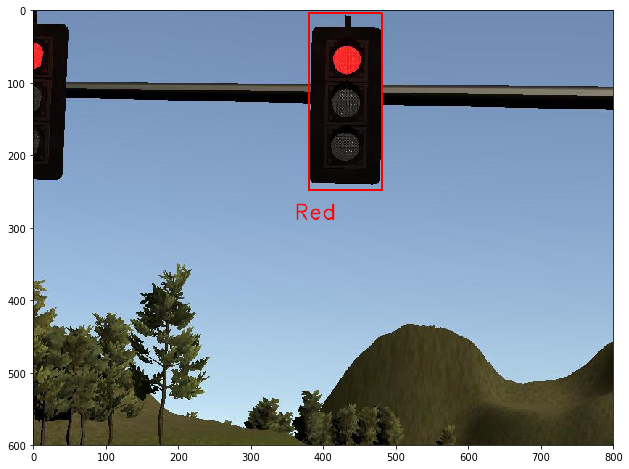

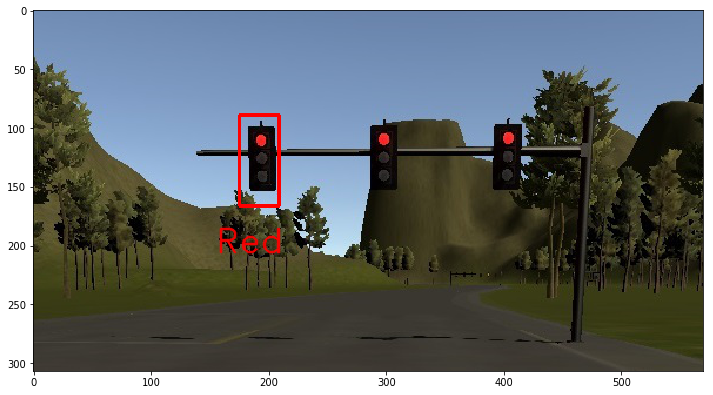

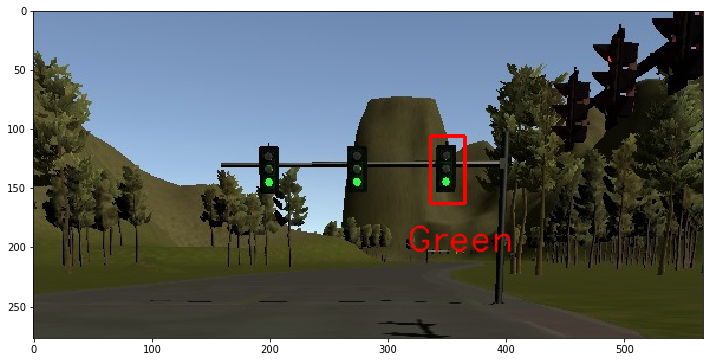

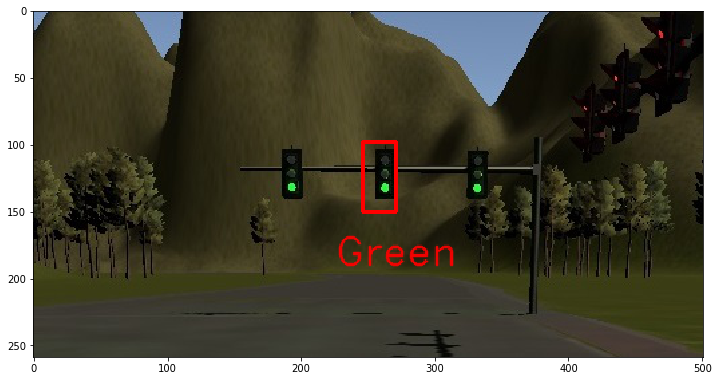

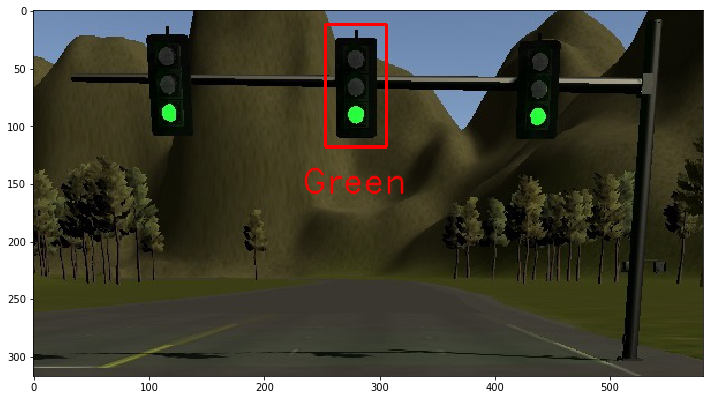

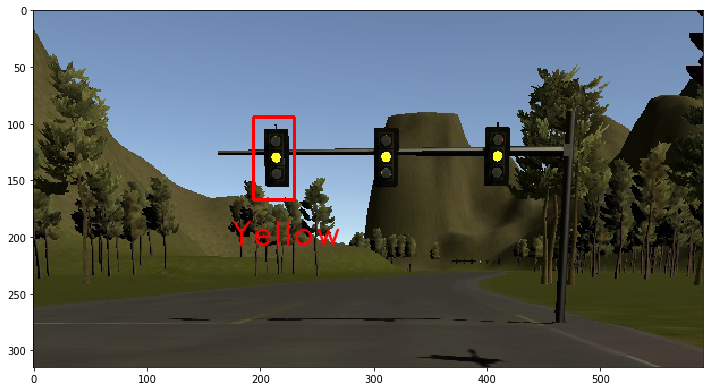

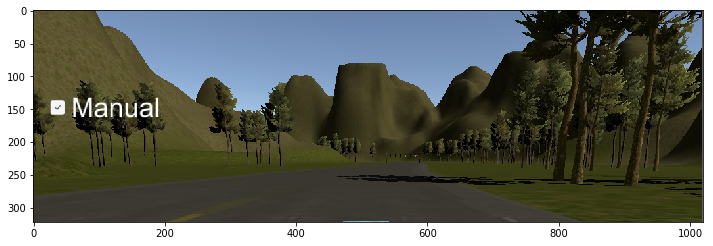

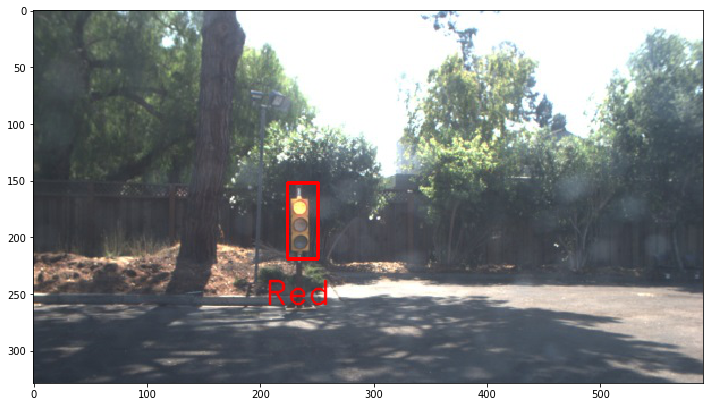

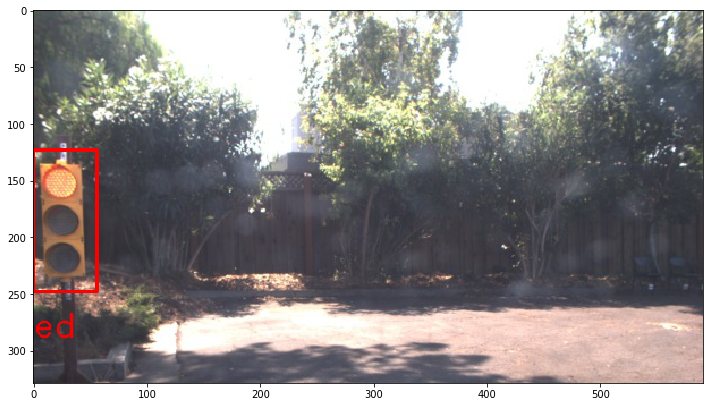

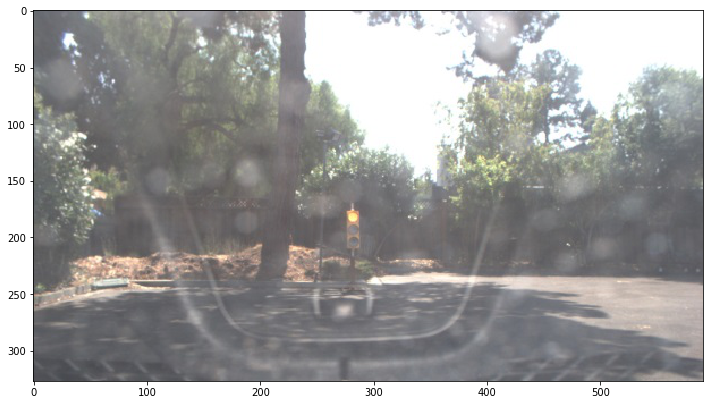

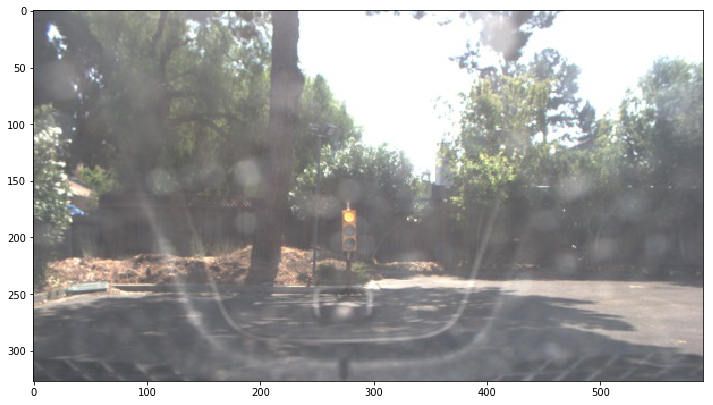

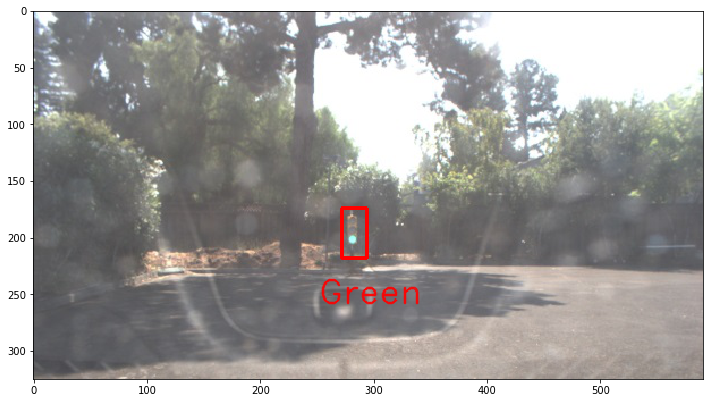

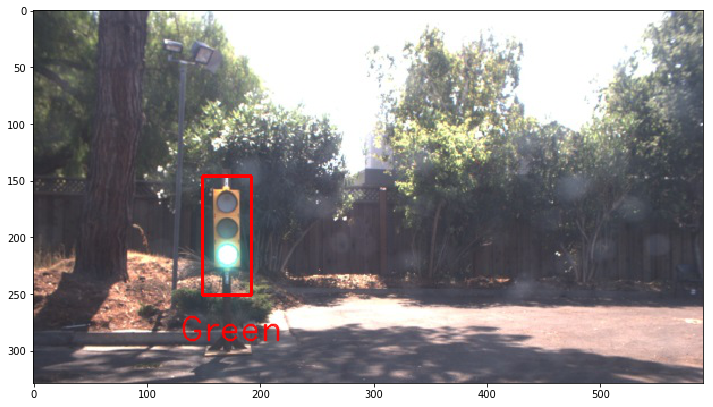

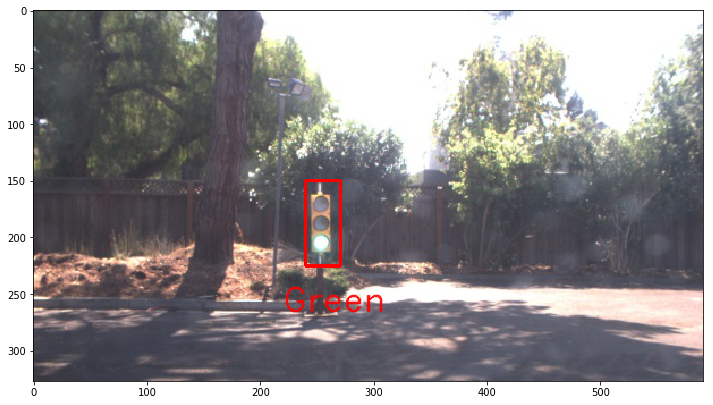

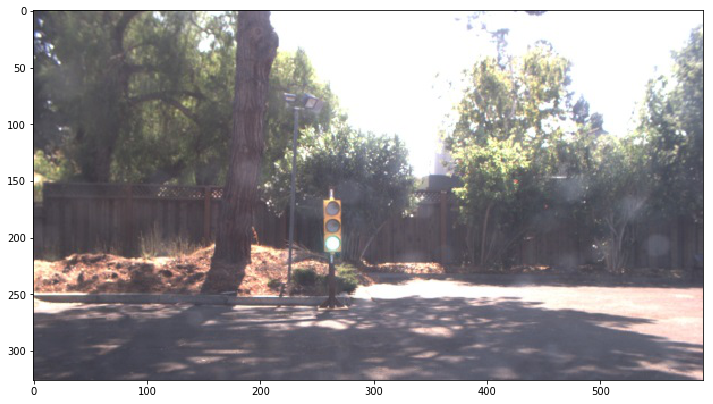

In [11]:
# Detection
boxList = []
with tf.Session(graph=graph_detection, config=config) as sess:    
    # Go through all images
    for i in range(0, len(images)): 
        # Load image and convert
        image = np.copy(images[i])
        im_height, im_width, _ = image.shape
        image_expanded = np.expand_dims(image, axis=0)
        
        # Do the inference
        boxes, scores, classes = sess.run(
          [detection_boxes, detection_scores, detection_classes],
          feed_dict={image_tensor: image_expanded})
        
        # Extract box and append to list
        box = extractBox(boxes, scores, classes, 0.1)
        boxList.append(box)

# Classification
trafficLights = []
with tf.Session(graph=graph_classification, config=config) as sess:   
    # Go through all images
    for i in range(0, len(images)): 
        box = boxList[i]
        image = np.copy(images[i])
        if box != None:
            left, right, top, bottom = box
            img_crop = image[top:bottom, left:right]
            traffic_light = cv2.resize(img_crop, (32, 32))
            sfmax = list(sess.run(tf.nn.softmax(out_graph.eval(feed_dict={in_graph: [traffic_light]}))))
            sf_ind = sfmax.index(max(sfmax))
            predicted_label = image_types[sf_ind]
            trafficLights.append(str(predicted_label))
        else:
            trafficLights.append('Unknown')
            
# Show results
for i in range(0, len(images)): 
    image = np.copy(images[i])
    box = boxList[i]
    trafficLight = trafficLights[i]
    # Draw the box if found
    if box != None:
        image = drawResult(box, trafficLight, image)
    # Draw image
    plt.figure(figsize=(12, 8))
    plt.imshow(image)

This part is only there to extract traffic lights from the ROSBag

In [15]:
# Load the images and store them into a list
images = []
for file in os.listdir("red_1"):
    image_path = "red_1/{}".format(file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    images.append(image)
    
print("Test images loaded!")

Test images loaded!


In [16]:
# Detection
count = 0
with tf.Session(graph=graph_detection, config=config) as sess:    
    # Go through all images
    for i in range(0, len(images)): 
        # Load image and convert
        image = np.copy(images[i])
        im_height, im_width, _ = image.shape
        image_expanded = np.expand_dims(image, axis=0)
        
        # Do the inference
        boxes, scores, classes = sess.run(
          [detection_boxes, detection_scores, detection_classes],
          feed_dict={image_tensor: image_expanded})
        
        # Extract box and append to list
        box = extractBox(boxes, scores, classes, 0.01)
        if box != None:
            left, right, top, bottom = box
            img_crop = image[top:bottom, left:right]
            img = cv2.cvtColor(img_crop, cv2.COLOR_RGB2BGR) 
            cv2.imwrite("red_1/simu_{}.jpg".format(count), img)
            count = count + 1